In [35]:
import cv2
from datetime import datetime
from io import BytesIO
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from picamera import PiCamera
import rpyc
from time import sleep

In [2]:
img=cv2.imread('gerald-way-umbrella-academy-1.jpg')

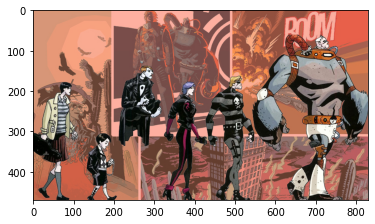

In [3]:
img_clr = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
plt.imshow(img_clr)

In [40]:
camera = PiCamera()
camera.resolution = (640,480)
camera.start_preview()

In [5]:
# Using video capture greatly speeds up the responsiveness (quality is less of course)
# It is possible to capture even faster using capture_sequence
# Documentation is on the following URL, since it complicates the code, it's probably best to leave this as a last resort
# https://picamera.readthedocs.io/en/release-1.13/recipes2.html#rapid-capture-and-processing
stream = BytesIO()
camera.capture(stream, format='jpeg', use_video_port=True)

In [6]:
# this code shows the more general stream capturing, however it's much easier to cirectly capture to an array
# See the update_image function below
stream.seek(0)
cam_img = cv2.imdecode(np.frombuffer(stream.read(), np.uint8), 1)
cam_img_clr = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGBA)

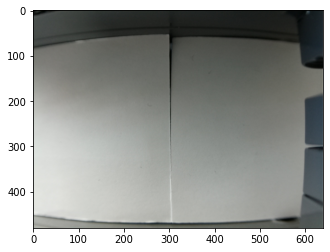

In [7]:
plt.imshow(cam_img_clr)

In [8]:
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bytes(cv2.imencode('.jpg', cam_img_clr)[1])
display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [9]:
processed_widget = ipywidgets.Image(format='jpeg')
display(processed_widget)

Image(value=b'', format='jpeg')

In [10]:
ev3_ip = '192.168.50.222'
ev3_connection = rpyc.classic.connect(ev3_ip)
ev3dev2_motor = ev3_connection.modules['ev3dev2.motor']

In [11]:
camera_motor = ev3dev2_motor.MediumMotor(ev3dev2_motor.OUTPUT_A)
main_motor = ev3dev2_motor.LargeMotor(ev3dev2_motor.OUTPUT_B)

In [65]:
top_border = 100
bottom_border = 40

def take_picture():
    cam_img = np.empty((640*480*3,), dtype=np.uint8)
    camera.capture(cam_img, format='bgr', use_video_port=True)
    return cam_img.reshape((480,640,3))
    
def pre_process_image(image):
    without_borders = image[top_border:480-bottom_border,:]
    gray = cv2.cvtColor(without_borders, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    return gray
    
first_image = pre_process_image(take_picture())

In [42]:
def bytes_to_jpg(img):
    return bytes(cv2.imencode('.jpg', img)[1])
    
def update_image():
    cam_img = take_picture()
    gray = pre_process_image(cam_img)
    
    image_diff = cv2.absdiff(first_image, gray)
    thresh = cv2.threshold(image_diff, 50, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    #thresh = cv.Canny(thresh, 40, 80)
    # Find contours
    #_, contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    left_most_contour_x = 640
    for c in contours:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 40:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 600 or w < 50:
            continue
        cv2.rectangle(cam_img, (x, y + top_border), (x + w, y + h + top_border), (0, 255, 0), 2)
        if x < left_most_contour_x:
            left_most_contour_x = x 

    image_widget.value = bytes_to_jpg(cam_img)
    processed_widget.value = bytes_to_jpg(thresh)
    return left_most_contour_x

In [43]:
def move_to_center(x):
    diff = 320 - x
    pixels_per_rotation = -90
    camera_motor.on_for_rotations(ev3dev2_motor.SpeedPercent(25), diff/pixels_per_rotation)

In [44]:
def write_image(image_bytes):
    filename = "data/" + datetime.now().strftime("%Y%m%d%H%M%S") + ".jpg"
    with open(filename, "wb") as file:
       file.write(image_bytes)

In [ ]:
import threading
from time import sleep
running = True
def update_image_loop():
    global running
    main_motor.on(ev3dev2_motor.SpeedPercent(-50))
    camera_motor.on(ev3dev2_motor.SpeedPercent(70))
    while running:
        contour_x = update_image()
        if  contour_x < 640:
            main_motor.stop()
            camera_motor.stop()
            move_to_center(contour_x)
            sleep(0.5)
            write_image(bytes_to_jpg(take_picture()))
            camera_motor.on_for_rotations(ev3dev2_motor.SpeedPercent(50), 10)
            sleep(0.5)
            main_motor.on(ev3dev2_motor.SpeedPercent(-50))
            camera_motor.on(ev3dev2_motor.SpeedPercent(70))
    camera_motor.stop()
    main_motor.stop()
        
t = threading.Thread(target=update_image_loop)
t.start()

In [67]:
running = False
t.join()

In [38]:
camera.stop_preview()
camera.close()

In [32]:
# testing some things, code below can be remove later
main_motor.on(ev3dev2_motor.SpeedPercent(-50))
camera_motor.on(ev3dev2_motor.SpeedPercent(70))

In [33]:
main_motor.stop()
camera_motor.stop()